# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Изучение данных из файла

Импортируем библиотеки, с которыми будем работать

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import seaborn as sbn
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Сохраняем данные в переменную `df`

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Всего в датафрейме 3214 строк и 5 колонок. 

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

Посмотрим общую информацию о данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Посмотрим описательную статистику по каждому столбцу датафрейма

In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


В таблице "Данные о поведении клиентов" 3214 объектов. Пропущенных значений нет.
В столбцах `calls` и `messages` содержится целочисленная информация. Заменим тип данных в них на `int16` для уменьшения занимаемого места.

In [5]:
df['calls'] = df['calls'].astype('int16')
df['messages'] = df['messages'].astype('int16')

Проведем корреляционный анализ факторов, для этого посчитаем коэффициент корреляции Пирсона.

In [6]:
corr_matrix = df.corr().round(2)
corr_matrix

,calls,minutes,messages,mb_used,is_ultra
calls,1.00,0.98,0.18,0.29,0.21
minutes,0.98,1.00,0.17,0.28,0.21
messages,0.18,0.17,1.00,0.20,0.20
mb_used,0.29,0.28,0.20,1.00,0.20
is_ultra,0.21,0.21,0.20,0.20,1.00


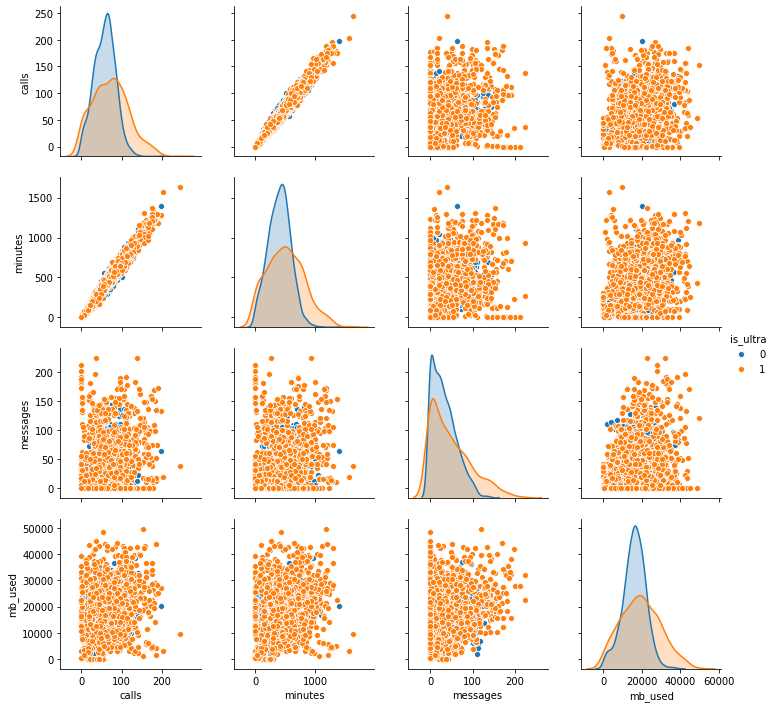

In [7]:
sbn.pairplot(df, vars = ['calls', 'minutes', 'messages', 'mb_used'], hue = 'is_ultra')
plt.show()

Как мы видим, звонки и минуты мультиколлинеарны, поэтому исключим из модели один из этих признаков, например, звонки.

Нам нужно построить модель для задачи классификации. Для этого разделим исходные данные на выборки.

## Разделение исходных данных на выборки

Для начала выделим в исходных данных:
* **признаки**: minutes, messages, mb_used
* **целевой признак**: is_ultra

In [8]:
features = df.drop(['calls','is_ultra'], axis=1)
target = df['is_ultra']

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно (60% на обучающию и по 20% данных на валидационную и тестовую выборки)

In [ ]:
df_train, df_valid = train_test_split(df, train_size=0.6, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)

print('Размер обучающей выборки', df_train.shape)
print('Размер валидационной выборки', df_valid.shape)
print('Размер тестовой выборки', df_test.shape)

Составим таблицы признаков и целевого признака для каждой выборки.

In [10]:
features_train = df_train.drop(['calls','is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['calls','is_ultra'], axis=1)
target_valid = df_valid['is_ultra']
features_test = df_test.drop(['calls','is_ultra'], axis=1)
target_test = df_test['is_ultra']

Мы разделили данные по принципу 60/20/20:

1. обучение проведем на данных `df_train`;
2. проверку модели - на данных `df_valid`;
3. лучшую модель по результатам проверки применим на данных `df_test`.

## Исследование моделей

### Дерево решений

Начнем с модели "Дерево решений" DecisionTreeClassifier. Изменим в цикле гиперпараметр `max_depth`. Критерием проверки качества модели будет точность `accuracy`.

In [11]:
best_depth = 0
best_accuracy = 0

for depth in range(1, 10):
    # инициализируем модель решающего дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    
    # обучаем модель
    model.fit(features_train, target_train)
    
    # находим предсказания на валидационной выборке
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    
    if accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = accuracy
        
print('Лучшая глубина дерева', best_depth,'Лучшая точность', best_accuracy)

Лучшая глубина дерева 4 Лучшая точность 0.7884914463452566


Модель "Дерево решений" с точностью 0,7885 удволетворяет условиям задачи. Перейдем к модели "Случайный лес".

### Случайный лес

1. Инициируем модель "Случайный лес" RandomForestClassifier

2. Выделим гиперпараметры для настройки модели:
 * `n_estimators` - число «деревьев» в «случайном лесу»;
 * `max_depth` - максимальная глубина деревьев;
 * `min_samples_leaf` - минимальное количество объектов в листьях;


3. Критерием проверки качества модели будет точность `accuracy`.

In [12]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
best_min_samples_leaf = 0

# количество деревьев: от 10 до 50 с шагом 10
for est in range(10, 51, 10):
    
    # максимальная глубина от 1 до 10
    for depth in range (1, 11):
        
        # минимальное число объектов в листьях от 1 до 10
        for min_samples_leaf in range (1, 11):
            
            # инициализируем модель случайного леса
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
            
            # обучаем модель на тренировочной выборке
            model.fit(features_train, target_train) 
            
            # проверяем качество модели на валидационной выборке
            result = model.score(features_valid, target_valid) 
            
            if result > best_result:
                best_model = model 
                best_result = model.score(features_valid, target_valid) 
                best_est = est
                best_depth = depth
                best_min_samples_leaf = min_samples_leaf
            
print('Accuracy наилучшей модели на валидационной выборке:', best_result, 
      'Количество деревьев:', best_est, 
      'Максимальная глубина:', depth,
      'Минимальное число объектов в листьях:', min_samples_leaf)

Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625 Количество деревьев: 20 Максимальная глубина: 10 Минимальное число объектов в листьях: 10


Точность модели "Случайный лес" выше на 1,12% по сравнению с моделью "Решающее дерево". 

### Логистическая регрессия

Инициализируем модель логистической регрессии с параметром `random_state=12345`

In [13]:
model = LogisticRegression(random_state=12345) 

# обучим модель на тренировочной выборке
model.fit(features_train, target_train) 

# получим метрику качества модели на валидационной выборке
result = model.score(features_valid, target_valid) 

print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.7076205287713841


Самая низкая точность классификации у модели логистической регрессии. 

Проверим модель "Случайный лес", которая показала лучшую точность `accuracy`, на тестовой выборке.

## Проверка модели на тестовой выборке

Наилучшая точность: 0.7994
Парамтеры модели: 
* n_estimators = 40
* max_depth = 10
* min_samples_leaf = 10

Проверим точность модели на тестовой выборке

In [14]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=10) 

# обучение модели на тренировочной выборке
model.fit(features_train, target_train) 

# проверяем качество модели на тестовой выборке
result = model.score(features_test, target_test) 

result

0.80248833592535

Мы проанализировали три модели классификации:
1. Дерево решений,
2. Случайный лес,
3. Логистическая регрессия.

Лучшую точность `accuracy` показала модель "Случайный лес":
* `accuracy` на тренировочной выборке: 0,7994
* `accuracy` на тестовой выборке: 0,8025.

Разница между точностью на тестовой и тренировочной выборках составляет всего 0,31%.

## Проверка модели на адекватность

Оценить адекватность модели можно используя классификатор DummyClassifier со стратегией most_frequent, которая всегда предсказывает наиболее частую метку в обучающем наборе.

In [15]:
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(features_train, target_train)
clf.score(features_test, target_test)

0.6842923794712286

Точность модели "Случайный лес" (accuracy = 0.80) выше, чем точность, полученная с DummyClassifier (accuracy = 0.68).

## Общий вывод

Для решения поставленной задачи мы изучили файл с данными, разделили исходные данные на три выборки:
1. обучающую,
2. валидационную,
3. тестовую.

Исследовали три модели классификации:
* Дерево решений,
* Случайный лес,
* Логистическая регрессия.

Наилучшую точность (accuracy) получили для модели "Случайный лес", проверили модель на тестовой выборке, оценили адекватность модели.